<a href="https://colab.research.google.com/github/igoravelli/brazilian_soccer_championship_analysis/blob/main/Average_of_cards_in_home_team_matches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and settings

In [2]:
import pandas as pd
import numpy as np

from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

data_table.enable_dataframe_formatter()
auth.authenticate_user()

project = 'brasileirao-362523'
schema = 'exp_brasileirao'
location = 'US'

client = bigquery.Client(project=project, location=location)

In [3]:
# @title get dim_match
dim_match = client.query(f"""
      SELECT * FROM `{project}.{schema}.exp_dimPartida`
    """).to_dataframe()

dim_match.set_index('pk_partida', inplace=True)
dim_match.head()

,estadio,visitante,mandante,rodada,data_partida,ano_campeonato,formacao_mandante,formacao_visitante,vencedor,perdedor
pk_partida,,,,,,,,,,
1,100028,1476,1340,1,2003-03-29 16:00:00,2003,N/A,N/A,guarani,vasco
2,100012,1319,1013,1,2003-03-29 16:00:00,2003,N/A,N/A,athletico-pr,gremio
3,100104,1183,1245,1,2003-03-30 16:00:00,2003,N/A,N/A,None,None
4,100144,1392,1299,1,2003-03-30 16:00:00,2003,N/A,N/A,None,None
5,100023,1393,1341,1,2003-03-30 16:00:00,2003,N/A,N/A,None,None


In [4]:
# @title get fact_events
fact_events = client.query(f"""
      SELECT * FROM `{project}.{schema}.exp_fatoEventos`
    """).to_dataframe()

fact_events.set_index('pk_fato', inplace=True)
fact_events.head()

,fk_id_partida,fk_id_time,fk_id_calendario,fk_id_jogador,fk_id_estadio,evento,minuto,acrescimo
pk_fato,,,,,,,,
2000001,4607,1268,20140419,16489,100104,gol,31,0
2000002,4607,1231,20140419,17611,100104,amarelo,44,0
2000003,4607,1268,20140419,12695,100104,gol,45,0
2000004,4607,1268,20140419,16029,100104,gol,59,0
2000005,4607,1231,20140419,16305,100104,amarelo,66,0


# Transformations

In [5]:
# @title join the dataframes dim_match, fact_events
mart = fact_events.merge(dim_match,
                         how = 'left',
                         left_on = 'fk_id_partida',
                         right_on = 'pk_partida')

mart.head()

,fk_id_partida,fk_id_time,fk_id_calendario,fk_id_jogador,fk_id_estadio,evento,minuto,acrescimo,estadio,visitante,mandante,rodada,data_partida,ano_campeonato,formacao_mandante,formacao_visitante,vencedor,perdedor
0,4607,1268,20140419,16489,100104,gol,31,0,100104,1231,1268,1,2014-04-19 18:28:00,2014,N/A,N/A,fluminense,figueirense
1,4607,1231,20140419,17611,100104,amarelo,44,0,100104,1231,1268,1,2014-04-19 18:28:00,2014,N/A,N/A,fluminense,figueirense
2,4607,1268,20140419,12695,100104,gol,45,0,100104,1231,1268,1,2014-04-19 18:28:00,2014,N/A,N/A,fluminense,figueirense
3,4607,1268,20140419,16029,100104,gol,59,0,100104,1231,1268,1,2014-04-19 18:28:00,2014,N/A,N/A,fluminense,figueirense
4,4607,1231,20140419,16305,100104,amarelo,66,0,100104,1231,1268,1,2014-04-19 18:28:00,2014,N/A,N/A,fluminense,figueirense


In [6]:
# @title select the columns
cols = [
    'fk_id_partida',
    'fk_id_time',
    'mandante',
    'evento'
]

df = mart[cols]

In [7]:
# @title create the is_home_team column
df['is_home_team'] = df['fk_id_time'] == df['mandante']

<ipython-input-7-49e494061cb1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_home_team'] = df['fk_id_time'] == df['mandante']


In [8]:
# @title pivot the dataframe
pivot = pd.pivot_table(df,
                       values = ['fk_id_partida'],
                       columns = ['evento'],
                       index = ['is_home_team'],
                       aggfunc = ['count'],
                       fill_value = 0)

pivot[[('count', 'fk_id_partida',  'total_matches')]] = len(df['fk_id_partida'].unique())
pivot.head()

count                             
             fk_id_partida                             
evento             amarelo   gol vermelho total_matches
is_home_team                                           
False                 8353  3130      500          3035
True                  7510  4715      331          3035

In [9]:
# @title get only the level 2 index column
pivot.columns = pivot.columns.get_level_values(2)

In [10]:
# @title create the columns with metrics
pivot['avg_cards'] = pivot.apply(lambda x: (x['amarelo'] + x['vermelho']) / x['total_matches'], axis=1)
pivot['avg_red_cards'] = pivot.apply(lambda x: x['vermelho'] / x['total_matches'], axis=1)
pivot['avg_yellow_cards'] = pivot.apply(lambda x: x['amarelo'] / x['total_matches'], axis=1)
pivot['avg_goals'] = pivot.apply(lambda x: x['gol'] / x['total_matches'], axis=1)

In [33]:
print(pivot.columns)
pivot.head()

Index(['amarelo', 'gol', 'vermelho', 'total_matches', 'avg_cards',
       'avg_red_cards', 'avg_yellow_cards', 'avg_goals'],
      dtype='object', name='evento')


evento,amarelo,gol,vermelho,total_matches,avg_cards,avg_red_cards,avg_yellow_cards,avg_goals
is_home_team,,,,,,,,
False,8353,3130,500,3035,2.916969,0.164745,2.752224,1.031301
True,7510,4715,331,3035,2.583526,0.109061,2.474465,1.553542


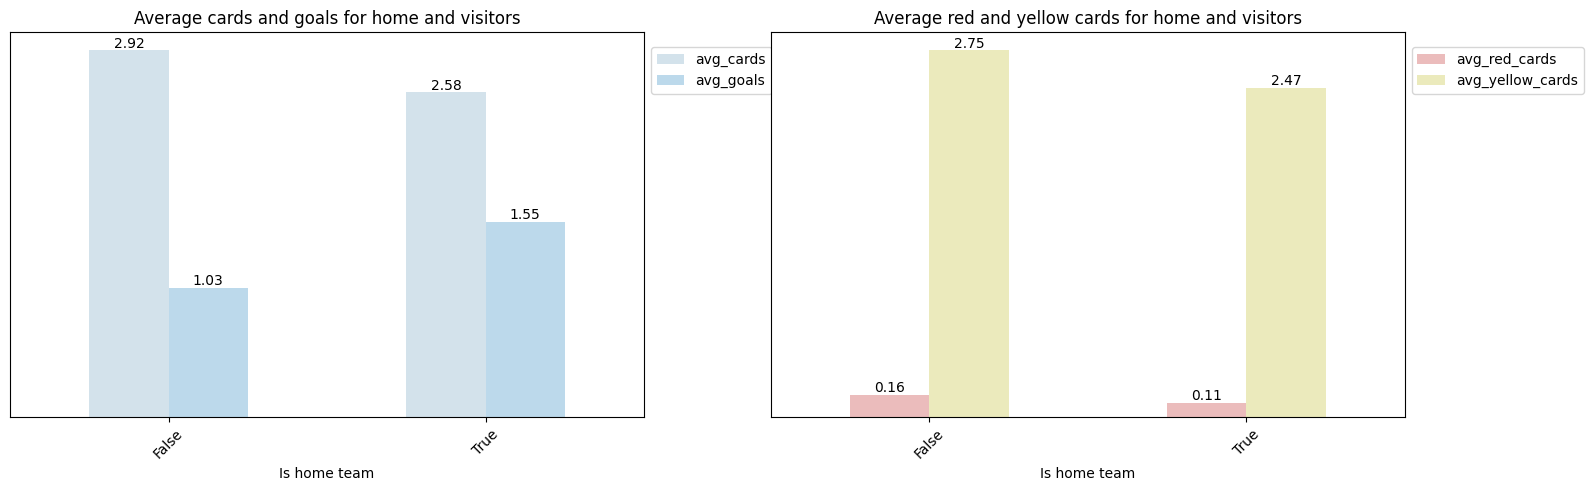

In [88]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows = 1,
                               ncols = 2,
                               figsize = (18,5))

xlabel = 'Is home team'

# first plot
pivot.plot(
    ax = ax1,
    kind = 'bar',
    y = ['avg_cards','avg_goals'],
    color = ['#D3E2EB', '#BCD9EB'],
    title = 'Average cards and goals for home and visitors',
    xlabel = xlabel,
    rot = 45
)

# second plot
pivot.plot(
    ax = ax2,
    kind = 'bar',
    y = ['avg_red_cards', 'avg_yellow_cards'],
    color = ['#EBBCBC', '#EBEABC'],
    title = 'Average red and yellow cards for home and visitors',
    xlabel = xlabel,
    rot = 45
)

for x in [ax1, ax2]:
    x.get_yaxis().set_visible(False)
    for p in x.patches:
        height = p.get_height()
        x.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', 
                    va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points')
    x.legend(loc = 'center left', bbox_to_anchor = (1, 0.9))


plt.show()


# Conclusion

As we can see in the chart above, the home teams receive fewer cards and make more goals.
The main observation is the average goal increase when a team plays at home, which was an increase of 50% on its average.

This can be explained by the pressure of the home public that makes visitors push harder.